**Sentiment Analysis**

Here i'll analyze `Tweets` and build a model to predict whether the Tweet is positive, negative or neutral.

# Importing required libraries

In [ ]:
!pip install keras-preprocessing  # Install the missing package

import zipfile
import numpy as np
import pandas as pd
from io import  BytesIO
from keras import Sequential
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from keras.utils import pad_sequences
from keras.utils import pad_sequences
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from keras_preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from keras.layers import Dense, SimpleRNN, Embedding, Flatten, Input,LSTM,GRU,Dropout

# Data Collection

In [ ]:
!mkdir -p ~/.kaggle # Create a .kaggle directory
!cp kaggle.json ~/.kaggle/ # Copy the kaggle.json file into the .kaggle directory
!chmod 600 ~/.kaggle/kaggle.json # Set appropriate permissions on the kaggle.json file to secure credentials

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d abhi8923shriv/sentiment-analysis-dataset # Download the Sentiment Analysis dataset from Kaggle

Dataset URL: https://www.kaggle.com/datasets/abhi8923shriv/sentiment-analysis-dataset
License(s): CC0-1.0
sentiment-analysis-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Create a ZipFile object to open the ZIP file located at '/content/dogs-vs-cats.zip' in read mode ('r')
zip_ref = zipfile.ZipFile('/content/sentiment-analysis-dataset.zip', 'r')

# Extract all contents of the ZIP file into the specified directory ('/content')
zip_ref.extractall('/content')

# Close the ZipFile object to free up resources
zip_ref.close()

In [ ]:
# Load training and validation datasets from CSV files with 'latin1' encoding

train_ds = pd.read_csv('/content/train.csv', encoding='latin1')
validation_ds = pd.read_csv('/content/test.csv', encoding='latin1')

# Data Cleaning and Preprocessing

**Explore the datasets**

In [ ]:
# Take two columns from dataset

train_ds = train_ds[['text','sentiment']]
validation_ds = validation_ds[['text','sentiment']]

In [ ]:
# print 5 sample data

validation_ds.sample(5)

,text,sentiment
2295,On the way back to dublin Omg didnt hit the be...,neutral
2345,walked home in the rain.,neutral
4656,NaN,NaN
2357,Working during graduation. What a shame.,negative
2221,He`s an amazing jockey! Saw that Clydesdale c...,positive


In [ ]:
# Drop missing values

train_ds = train_ds.dropna()
validation_ds = validation_ds.dropna()

In [ ]:
# print shape of the training and validation dataset

print('Shape of the training data:',train_ds.shape)
print('Shape of the validation data:',validation_ds.shape)

Shape of the training data: (27480, 2)
Shape of the validation data: (3534, 2)


# ploting

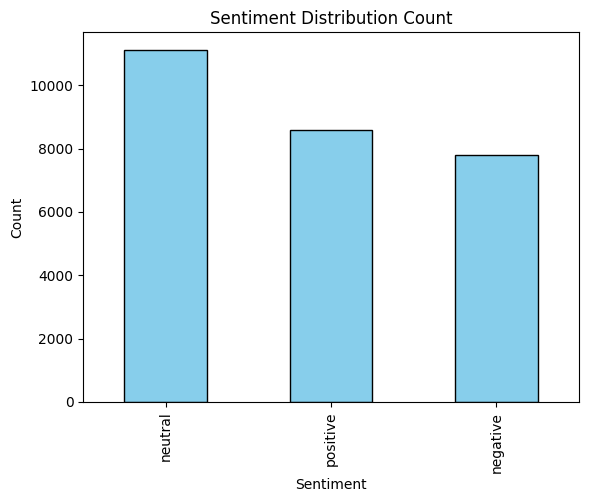

In [ ]:
# Plot the bar plot
train_ds['sentiment'].value_counts().plot.bar(color='skyblue', edgecolor='black')

# Add title and labels
plt.title('Sentiment Distribution Count')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Show the plot
plt.show()

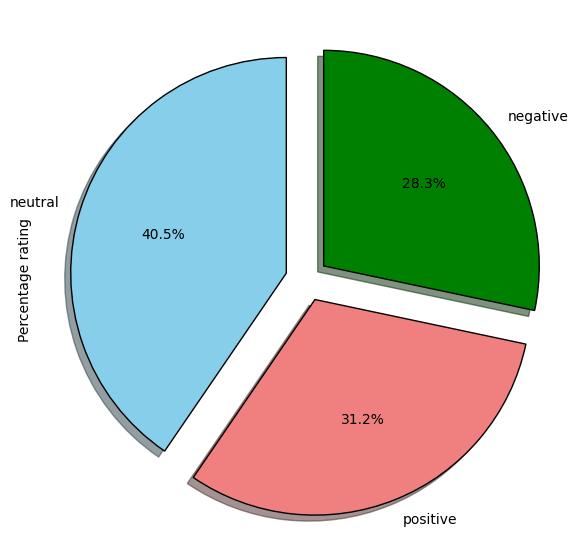

In [ ]:
fig = plt.figure(figsize=(7,7))

colors = ('skyblue', 'lightcoral', 'green')

wp = {'linewidth':1, "edgecolor":'black'}

tags = train_ds['sentiment'].value_counts()/train_ds.shape[0]

# Calculate the number of sentiment categories
num_categories = len(tags)

# Create an explode tuple with the correct length
explode = (0.1,) * num_categories

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage rating')

graph = BytesIO()

fig.savefig(graph, format="png")

`40.5%` -- Neutral.

`31.2%` -- Positive.

`28.3%` -- Negative.

# Feature Engineering

In [ ]:
# Define a function to convert sentiment labels to numeric values
def function(sentiment):
    # If the sentiment is 'positive', return 0
    if sentiment == 'positive':
        return 0
    # If the sentiment is 'negative', return 1
    elif sentiment == 'negative':
        return 1
    # For any other sentiment, return 2
    else:
        return 2

# Apply the function to the 'sentiment' column of the train dataset
train_ds['sentiment'] = train_ds['sentiment'].apply(function)

# Apply the same function to the 'sentiment' column of the validation dataset
validation_ds['sentiment'] = validation_ds['sentiment'].apply(function)

In [ ]:
# Convert the 'text' column from the dataset into a numpy array

x_train = np.array(train_ds['text'].tolist())
y_train = np.array(train_ds['sentiment'].tolist())
x_test = np.array(validation_ds['text'].tolist())
y_test = np.array(validation_ds['sentiment'].tolist())

In [ ]:
# Print X_train

x_train

array([' I`d have responded, if I were going',
       ' Sooo SAD I will miss you here in San Diego!!!',
       'my boss is bullying me...', ...,
       ' Yay good for both of you. Enjoy the break - you probably need it after such hectic weekend  Take care hun xxxx',
       ' But it was worth it  ****.',
       '   All this flirting going on - The ATG smiles. Yay.  ((hugs))'],
      dtype='<U159')

In [ ]:
# Print y_test

y_test

array([2, 0, 1, ..., 1, 0, 0])

In [ ]:
# Convert the training and testing labels to one-hot encoded format

y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [ ]:
# Initialize the Tokenizer with a maximum number of words
tokenizer = Tokenizer(num_words=2000)

# Fit the tokenizer on the training data
tokenizer.fit_on_texts(x_train)

In [ ]:
len(tokenizer.word_index)

26598

In [ ]:
# Convert text to sequences of integers

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [ ]:
# Pad the sequences

x_train = pad_sequences(x_train, padding='post', maxlen=30)
x_test = pad_sequences(x_test, padding='post', maxlen=30)

In [ ]:
x_train[49]

array([ 385, 1001,    1,   49,    4,   75,   54,   98,  133,    8,    1,
         21,   27,   26,   29,   24,  382,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
x_train.shape

(27480, 30)

# Model Building

"I'll begin with `Machine Learning` models.

**Machine Learning Models**

In [ ]:
# Convert one-hot encoded labels to single integer labels
y_train_int = np.argmax(y_train, axis=1)
y_test_int = np.argmax(y_test, axis=1)

models = {
    'Logistic Regression': LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Support Vector Classifier': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

# Dictionary to store accuracy results
results = {}

# Train and evaluate each model
for name, model in models.items():
    # Train the model
    model.fit(x_train, y_train_int)

    # Predict on training data
    y_train_pred = model.predict(x_train)
    train_accuracy = accuracy_score(y_train_int, y_train_pred)

    # Predict on test data
    y_test_pred = model.predict(x_test)
    test_accuracy = accuracy_score(y_test_int, y_test_pred)

    # Store the results
    results[name] = {
        'Training Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy
    }

# Display the results
for name, accuracy in results.items():
    print(f"{name}:")
    print(f" - Training Accuracy: {accuracy['Training Accuracy']:.4f}")
    print(f" - Test Accuracy: {accuracy['Test Accuracy']:.4f}")
    print()


Logistic Regression:
 - Training Accuracy: 0.4064
 - Test Accuracy: 0.3998

Decision Tree:
 - Training Accuracy: 0.9963
 - Test Accuracy: 0.4151

Random Forest:
 - Training Accuracy: 0.9963
 - Test Accuracy: 0.4383

Gradient Boosting:
 - Training Accuracy: 0.5092
 - Test Accuracy: 0.4584

Support Vector Classifier:
 - Training Accuracy: 0.4844
 - Test Accuracy: 0.3981

K-Nearest Neighbors:
 - Training Accuracy: 0.5749
 - Test Accuracy: 0.3732

Naive Bayes:
 - Training Accuracy: 0.3201
 - Test Accuracy: 0.3186



`I observed poor accuracy and signs of overfitting, so I'll proceed with Deep RNN.`

#### Deep RNN

In [ ]:
# Define and build a Sequential model with embedding, GRU layers, dropout, and a dense output layer for multi-class classification.


model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=5, input_length=30))
model.add(GRU(100, return_sequences=True))
Dropout(0.5)
model.add(GRU(50))
model.add(Flatten())
model.add(Dense(3, activation='sigmoid'))
model.build(input_shape=(None, 30))

In [ ]:
# Display a summary of the model's architecture and parameters

model.summary()

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_35 (Embedding)             │ (None, 30, 5)               │         100,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_55 (GRU)                         │ (None, 30, 100)             │          32,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_56 (GRU)                         │ (None, 50)                  │          22,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 3)                   │             153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,053 (605.68 KB)

 Trainable params: 155,053 (605.68 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model with Adam optimizer and categorical crossentropy loss for multi-class classification

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
 # Stop training when no improvement, restoring best weights

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

In [ ]:
# Train the model for 50 epochs with validation and early stopping

history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stopping])

Epoch 1/50
859/859 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.4049 - loss: 1.0881 - val_accuracy: 0.4046 - val_loss: 1.0873
Epoch 2/50
859/859 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.4107 - loss: 1.0822 - val_accuracy: 0.6183 - val_loss: 0.8754
Epoch 3/50
859/859 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6633 - loss: 0.8209 - val_accuracy: 0.6989 - val_loss: 0.7471
Epoch 4/50
859/859 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7159 - loss: 0.7156 - val_accuracy: 0.7026 - val_loss: 0.7267
Epoch 5/50
859/859 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7248 - loss: 0.6877 - val_accuracy: 0.7040 - val_loss: 0.7014
Epoch 6/50
859/859 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7328 - loss: 0.6545 - val_accuracy: 0.7060 - val_loss: 0.6930
Epoch 7/50
859/859 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7473 - loss: 0.6244 - val_accuracy: 0.7162 - val_loss: 0.6715
Epoch 8/50
859/859 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.7659 - loss: 0.5839 - val_accuracy:

#### Plotting graphs for traning and validation score

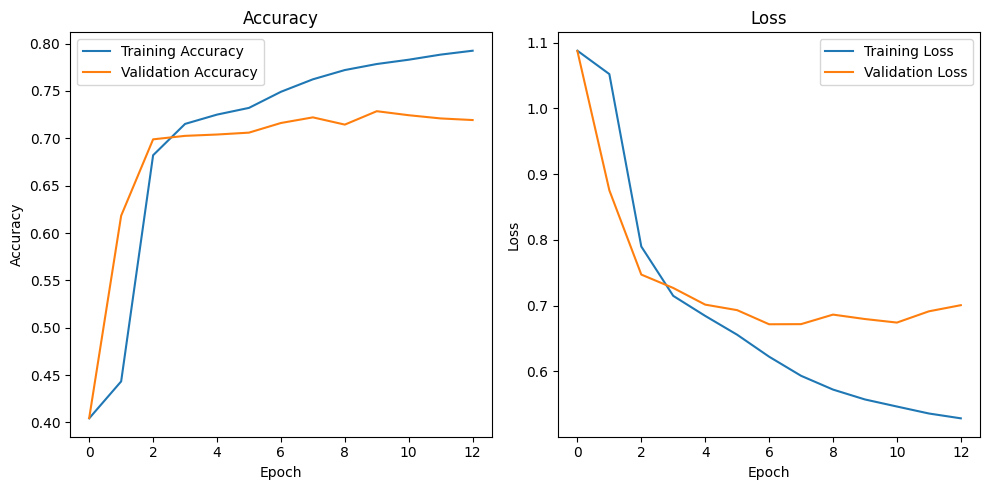

In [ ]:
# Create a figure with 1 row and 2 columns of subplots
plt.figure(figsize=(10, 5))

# Plot accuracy
plt.subplot(1, 2, 1)  # (rows, columns, index)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)  # (rows, columns, index)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


#### Make Predictions

In [ ]:
# Example texts
text1 = "The movie was bad bad bad, I will not recommend this movie to anyone"
text2 = "This is my day, I hope this will be a great day for me."
text3 = 'The price of one kg potato is 100BDT.'

# Tokenize and pad sequences
new_text_seq = tokenizer.texts_to_sequences([text1, text2, text3])  # Tokenize new texts
new_text_padded = pad_sequences(new_text_seq, padding='post', maxlen=35)  # Use max_len determined during training

# Make predictions
predictions = model.predict(new_text_padded)

# Get the class with the highest probability
predicted_class_index = predictions.argmax(axis=-1)

# Map indices to sentiment labels
sentiment_labels = {0: "Positive Sentiment", 1: "Negative Sentiment", 2: "Neutral Sentiment"}

# Print predictions
for i, text in enumerate([text1, text2, text3]):
    print(f"Text: '{text}'")
    print(f"Predicted Sentiment: {sentiment_labels[predicted_class_index[i]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Text: 'The movie was bad bad bad, I will not recommend this movie to anyone'
Predicted Sentiment: Negative Sentiment
Text: 'This is my day, I hope this will be a great day for me.'
Predicted Sentiment: Positive Sentiment
Text: 'The price of one kg potato is 100BDT.'
Predicted Sentiment: Positive Sentiment


**Predictions:**

Text1: *'The movie was bad bad bad, I will not recommend this movie to anyone'*

Predicted Sentiment: **`Negative Sentiment`**

Text2: *'This is my day, I hope this will be a great day for me.'*

Predicted Sentiment: **`Positive Sentiment`**

Text2: *'The price of one kg potato is 100BDT.'*

Predicted Sentiment: **`Neutral Sentiment`**